# Applying Machine Learning Models to Data From Catalog

### Heavily based on SciPy 2015 ScikitLearn Tutorial by Jake Vanderplas
https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/03.1-Classification-SVMs.ipynb

In [1]:
import scipy
from scipy import *
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cross_validation import train_test_split


from globusonline.catalog.client.catalog_wrapper import *
from globusonline.catalog.client.operators import Op
from globusonline.catalog.client.rest_client import RestClientError
%matplotlib inline

# Styling

In [2]:
sns.set_context("talk", font_scale=1.3)

ben_style = {'axes.axisbelow': True,
 'axes.edgecolor': '0',
 'axes.facecolor': 'white',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'axes.linewidth': 1,
 'figure.facecolor': 'white',
 'font.family': [u'sans-serif'],
             'font.size': 75,
 'font.sans-serif': [u'Helvetica Neue',
  u'Liberation Sans',
  u'Bitstream Vera Sans',
  u'sans-serif'],
 'grid.color': '0.9',
 'grid.linestyle': u'',
 'image.cmap': u'Greys',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': u'round',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': u'in',
 'xtick.major.size': 3.0,
 'xtick.minor.size': 2.0,
 'ytick.color': '.15',
 'ytick.direction': u'in',
 'ytick.major.size': 3.0,
 'ytick.minor.size': 2.0}

sns.set_style("white", ben_style)

# Helper Functions

In [3]:
def catalog_insert_df(df, catalog_id, dataset_name='Untitled', create_tags=True):
    tag_types = {dtype('O'):'text', dtype('int64'):'int8', dtype('float64'):'float8'}
    tags = []
    
    #Create the necessary tag defs in the catalog
    if create_tags:
        for key in df.keys():
            tags.append({})
            try:
                _,response = client.create_annotation_def \
                    (catalog_id=catalog_id, annotation_name=key, value_type=tag_types[df[key].dtype])
            except Exception, e:
                print e
                pass
            
    #Create the dataset 
    _,result = client.create_dataset(catalog_id,{'name':dataset_name})
    dataset_id = result['id']
    
    #Gather the member data
    members = []
    for row in df.iterrows():
        tmp_dict = {}
        for key in row[1].keys():
            tmp_dict[key] = row[1][key]
        members.append(tmp_dict)
    
    #Create the members using bulk insert
    _,result = client.create_members(catalog_id, dataset_id, members)
    return (catalog_id, dataset_id)

def dataframe_from_catalog(catalog_id, dataset_id, columns):    
    catalog_annotations = []
    bad_annotations = []
    _,result = client.get_annotation_defs(catalog_id)
    for annotation in result:
        catalog_annotations.append(annotation['name'])
    
    #print catalog_annotations
        
    black_list = ['readok', 'owner', 'writeok', 'created', 'modified', 'modified by']
    for item in black_list:
        try:   
            catalog_annotations.remove(item)
        except Exception, e:
            pass

    
    member_annotations = []
    _,member_annotations = client.get_all_member_annotations(catalog_id,dataset_id,'',columns,limit=200)
    
    return pd.DataFrame(member_annotations)

def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    sns.despine()



# Handle Authentication

In [4]:
# Store authentication data in a local file
token_file = os.getenv('HOME','')+"/.ssh/gotoken.txt"
wrap = CatalogWrapper(token_file=token_file)
client = wrap.catalogClient

# Creating Test Data (optional)

In [5]:
# Making a test dataset
# This is how you could make a test dataset
# X, y = make_blobs(n_samples=100, centers=2, cluster_std=0.60)
# plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring');
# sns.despine()

# Push Data from a csv into a Catalog Dataset (optional)

In [6]:
# filepath = "./datasets/blobs.csv"
# catalog_id = 148
# dataset_title = "My ML Dataset"

# #Read from csv into a dataframe
# df = pd.read_csv(filepath)
# data_columns = list(df.columns.values)

# #Insert into catalog
# catalog_id, dataset_id = catalog_insert_df(df, catalog_id, dataset_title, create_tags=True)

# Load Dataset from a Catalog into a Dataframe
### Using a preloaded two-class blob dataset

In [13]:
filepath = "./datasets/blobs.csv"
df = pd.read_csv(filepath)
data_columns = list(df.columns.values)
catalog_id = 148
dataset_id = 54
ml_df = dataframe_from_catalog(catalog_id, dataset_id, data_columns)

/catalog/id=148/dataset/id=54/member
/catalog/id=148/dataset/id=54/member/sample;x;y;class;data_type;data_uri/annotation/sample;x;y;class;data_type;data_uri?limit=200


In [14]:
ml_df.head(5)

,class,data_type,data_uri,id,sample,x,y
0,0,file,globus://go#ep1/share/godata/file1 .txt,55,1,6.70,5.76
1,1,file,globus://go#ep1/share/godata/file2 .txt,56,2,4.18,8.46
2,1,file,globus://go#ep1/share/godata/file3 .txt,57,3,3.96,7.78
3,0,file,globus://go#ep1/share/godata/file4 .txt,58,4,6.57,5.64
4,1,file,globus://go#ep1/share/godata/file5 .txt,59,5,4.01,8.58


# Visualize the Dataset

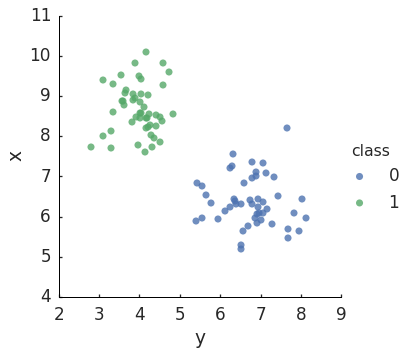

In [15]:
fig = sns.lmplot(x="x", y="y", data=df, order=2, hue="class", fit_reg=False, scatter_kws={"s": 50});
fig.ax.set_ylabel('x')
fig.ax.set_xlabel('y')
sns.despine()

# Perform Support Vector Classification on the Dataset and Plot Decision Function and Support Vectors

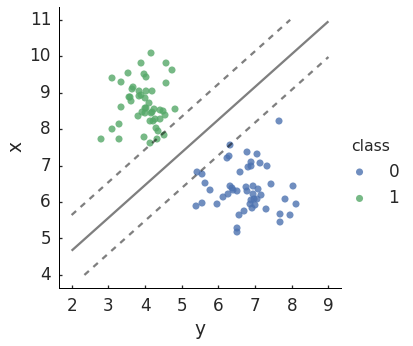

In [34]:
from sklearn.svm import SVC # "Support Vector Classifier"
from sklearn.metrics import confusion_matrix
clf = SVC(kernel='linear')
clf.fit(df[['x','y']], df['class'])
fig = sns.lmplot(x="x", y="y", data=df, order=1, hue="class", fit_reg=False, scatter_kws={"s": 50});
fig.ax.set_ylabel('x')
fig.ax.set_xlabel('y')

plot_svc_decision_function(clf);

# Model Validation and Scoring

## Split Dataset into Training and Test Dataset

In [50]:
x_train, x_test, class_train, class_test = train_test_split(df[['x','y']], df['class'], 
                                                    test_size=0.2)

## Model and make predictions

In [51]:
clf = SVC(kernel='linear')
class_pred = clf.fit(x_train, class_train).predict(x_test)

## Score the Model and Visualize Output Errors

[[12  0]
 [ 0  8]]
Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


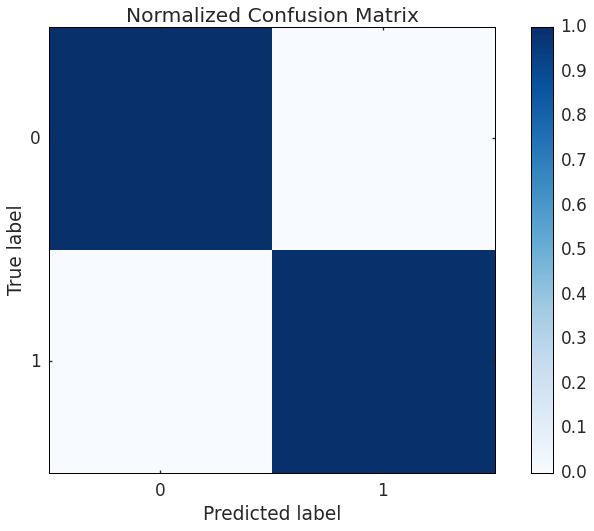

In [61]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.xticks([0,1], [0,1])
    plt.yticks([0,1], [0,1])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(class_test, class_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm
print('Normalized confusion matrix')
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title="Normalized Confusion Matrix")